# **Deep Hedging**

This notebook aims at implementing Deep Hedging to showcase the effect of transaction costs on the hedging and pricing of an option, the easiest way possible for now

To do so, we simulate paths of an asset following a Geometric Brownian Motion, we define a portfolio consisting of shares in this asset and a short position in a call option and we try to maximize the expected utility of the termianl wealth in the portfolio, by controling the number of shares in the portfolio

In Deep hedging, the control is chosen by a neural network policy which will be trained by Monte Carlo simulations

In [115]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [116]:
# Parameters
gamma = 0.1 # Risk aversion parameter
lambda_tc = 0.000001 # Proportional transaction costs 
# --- Underlying parameters ---
S0 = 100
mu = 0.05
sigma = 0.2
# -----------------------------
# --- Option parameters ---
T = 1.0
strike = 100
N_steps = 30
# -------------------------
# --- Policy parameters ---
clip_trade = 2.0
clip_pos = 10.0
batch_size = 64
epochs = 3000
# -------------------------

In [117]:
# ---------------------------------------------------------
# Underlying path simulation
# ---------------------------------------------------------
def simulate_gbm(S0, mu, sigma, T, N_steps, batch_size):
    dt = T / N_steps
    S = np.full((batch_size, N_steps+1), S0)
    for t in range(1, N_steps+1):
        z = np.random.randn(batch_size)
        S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return S  # shape: [batch_size, N_steps+1]

# ---------------------------------------------------------
# Utility function
# ---------------------------------------------------------
def cara_utility(w, gamma):
    exp_arg = torch.clamp(-gamma * w, min=-100, max=100)
    utility = - torch.exp(exp_arg)
    return utility

# ---------------------------------------------------------
# BS Delta for initialization
# ---------------------------------------------------------
def bs_call_delta(S, K, sigma, T, t):
    tau = T - t
    if tau <= 0:
        return (S > K).astype(float)
    d1 = (np.log(S / K) + 0.5 * sigma**2 * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)


# ---------------------------------------------------------
# Computation of the terminal wealth for a path and policy 
# ---------------------------------------------------------
def compute_terminal_wealth(S_path, trades, strike, lambda_tc):
    y = 0
    cash = 0
    for t in range(len(trades)):
        d_y = trades[t]
        price = S_path[t]
        cost = lambda_tc * abs(d_y) * price
        cash -= d_y * price + cost
        y += d_y
    # At expiry
    S_T = S_path[-1]
    # Liquidate
    cash += y * S_T - lambda_tc * abs(y) * S_T
    # Payoff (short call)
    payoff = max(S_T - strike, 0)
    return cash - payoff

def compute_terminal_wealth_no_option(S_path, trades, lambda_tc):
    y = 0
    cash = 0
    for t in range(len(trades)):
        d_y = trades[t]
        price = S_path[t]
        cost = lambda_tc * abs(d_y) * price
        cash -= d_y * price + cost
        y += d_y
    # At expiry
    S_T = S_path[-1]
    # Liquidate 
    cash += y * S_T - lambda_tc * abs(y) * S_T
    return cash


In [118]:
# ---------------------------------------------------------
# Policy Neural Network : A simple Feed Forward Network
# ---------------------------------------------------------
class SimplePolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.fc(x)

In [119]:
# ---------------------------------------------------------
# Training function, takes option as input, to be able to train with and without the option
# ---------------------------------------------------------


def train(policy, optimizer, epochs, option=True):
    utility_history = []
    wealth_history = []
    loss_history = []
    for epoch in range(epochs):
        # Simulate batch of paths
        S_paths = simulate_gbm(S0, mu, sigma, T, N_steps, batch_size)
        S_paths = torch.tensor(S_paths, dtype=torch.float32)

        y = torch.zeros(batch_size)
        trades = []
        for t in range(N_steps):
            price = S_paths[:, t]
            time_feat = torch.full((batch_size, 1), t/N_steps)
            y_feat = y.unsqueeze(1)
            x = torch.cat([price.unsqueeze(1)/S0, time_feat, y_feat], dim=1)
            d_y = policy(x).squeeze(1)
            d_y = torch.clamp(d_y, -clip_trade, clip_trade)
            trades.append(d_y)
            y = torch.clamp(y + d_y, -clip_pos, clip_pos)

        cash = torch.zeros(batch_size)
        y = torch.zeros(batch_size)
        for t in range(N_steps):
            d_y = trades[t]
            price = S_paths[:, t]
            cost = lambda_tc * torch.abs(d_y) * price
            cash = cash - d_y * price - cost
            y = torch.clamp(y + d_y, -clip_pos, clip_pos)
        S_T = S_paths[:, -1]
        cash = cash + y * S_T - lambda_tc * torch.abs(y) * S_T
        payoff = torch.relu(S_T - strike)
        if option:
            terminal_wealth = cash - payoff
        else:
            terminal_wealth = cash
        terminal_wealth = torch.clamp(terminal_wealth, min=-200, max=200)
        utility = - torch.exp(-gamma * terminal_wealth)
        loss = -utility.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        utility_history.append(utility.mean().item())
        wealth_history.append(terminal_wealth.mean().item())
        loss_history.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: loss = {loss:.4f}, mean terminal wealth = {terminal_wealth.mean().item():.2f}")

    plt.plot(loss_history)
    plt.xlabel('Epochs')
    plt.ylabel(f'Loss (-E(U)), with option = {option}')
    plt.show()
    return utility_history, wealth_history


## Here we first train the two models to align with BS delta hedging or to do nothing (no option case), so there isn't problems regarding initialization

In [120]:
S_grid = np.linspace(0.5*S0, 1.5*S0, 100)
t_grid = np.linspace(0, T, N_steps+1)
y_grid = np.array([0.0])  # Usually zero initial hedge

inputs = []
deltas = []

for t in t_grid:
    for S in S_grid:
        delta = bs_call_delta(S, strike, sigma, T, t)
        inputs.append([S/S0, t/T, 0.0])  # Normalized inputs as used in your NN
        deltas.append(delta)
        
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
deltas_tensor = torch.tensor(deltas, dtype=torch.float32).unsqueeze(1)

policy = SimplePolicyNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

# Short supervised training (initialization only)
epochs_init = 200  # short training to approximate delta

for epoch in range(epochs_init):
    optimizer.zero_grad()
    outputs = policy(inputs_tensor)
    loss = criterion(outputs, deltas_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Initialization loss = {loss.item():.6f}")


inputs_zero = inputs_tensor
outputs_zero = torch.zeros_like(deltas_tensor)

policy_no_option = SimplePolicyNet()
optimizer_no_option = torch.optim.Adam(policy_no_option.parameters(), lr=1e-3)

epochs_init_zero = 200

for epoch in range(epochs_init_zero):
    optimizer_no_option.zero_grad()
    outputs = policy_no_option(inputs_zero)
    loss = criterion(outputs, outputs_zero)
    loss.backward()
    optimizer_no_option.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Zero initialization loss = {loss.item():.6f}")


Epoch 0: Initialization loss = 0.466556
Epoch 100: Initialization loss = 0.021579
Epoch 0: Zero initialization loss = 0.029619
Epoch 100: Zero initialization loss = 0.000003


In [121]:
# ---------------------------------------------------------
# Training 
# ---------------------------------------------------------

policy = policy
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-5)
utility_with, wealth_with = train(policy, optimizer, epochs=epochs, option=True)

policy_no_option = policy_no_option
optimizer_without = torch.optim.Adam(policy_no_option.parameters(), lr=1e-5)
utility_without, wealth_without = train(policy_no_option, optimizer, epochs, option=False)

Epoch 0: loss = 485165120.0000, mean terminal wealth = -200.00
Epoch 100: loss = 485165120.0000, mean terminal wealth = -200.00
Epoch 200: loss = 485165120.0000, mean terminal wealth = -200.00
Epoch 300: loss = 485165120.0000, mean terminal wealth = -200.00


KeyboardInterrupt: 

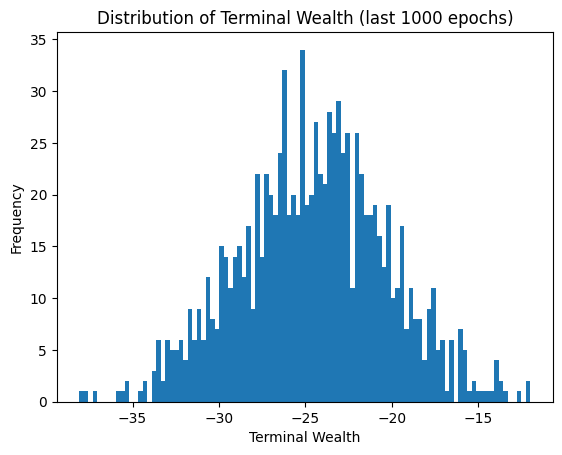

In [ ]:
plt.hist(wealth_with[epochs-1000:], bins=100)
plt.title("Distribution of Terminal Wealth (last 1000 epochs)")
plt.xlabel("Terminal Wealth")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# ---------------------------------------------------------
# Evaluate function, to run simulations with the trained policy
# ---------------------------------------------------------

def evaluate(policy, n_paths=10000, option=True):
    policy.eval()  # set policy to evaluation mode (good practice)
    with torch.no_grad():
        S_paths = simulate_gbm(S0, mu, sigma, T, N_steps, n_paths)
        S_paths = torch.tensor(S_paths, dtype=torch.float32)

        y = torch.zeros(n_paths)
        trades = []
        for t in range(N_steps):
            price = S_paths[:, t]
            time_feat = torch.full((n_paths, 1), t/N_steps)
            y_feat = y.unsqueeze(1)
            x = torch.cat([price.unsqueeze(1)/S0, time_feat, y_feat], dim=1)
            d_y = policy(x).squeeze(1)
            d_y = torch.clamp(d_y, -clip_trade, clip_trade)
            trades.append(d_y)
            y = torch.clamp(y + d_y, -clip_pos, clip_pos)

        cash = torch.zeros(n_paths)
        y = torch.zeros(n_paths)
        for t in range(N_steps):
            d_y = trades[t]
            price = S_paths[:, t]
            cost = lambda_tc * torch.abs(d_y) * price
            cash = cash - d_y * price - cost
            y = torch.clamp(y + d_y, -clip_pos, clip_pos)
        S_T = S_paths[:, -1]
        cash = cash + y * S_T - lambda_tc * torch.abs(y) * S_T
        payoff = torch.relu(S_T - strike)
        if option:
            terminal_wealth = cash - payoff
        else:
            terminal_wealth = cash
        terminal_wealth = torch.clamp(terminal_wealth, min=-1e3, max=1e3)
        utility = - torch.exp(-gamma * terminal_wealth)
        # Return full batch for statistical estimation
        return terminal_wealth.numpy(), utility.numpy()


In [ ]:
# Evaluate expected exp(-gamma * terminal_wealth) for both cases

def expected_exp_utility(policy, option=True, n_paths=10000):
    policy.eval()
    with torch.no_grad():
        S_paths = simulate_gbm(S0, mu, sigma, T, N_steps, n_paths)
        S_paths = torch.tensor(S_paths, dtype=torch.float32)

        y = torch.zeros(n_paths)
        trades = []
        for t in range(N_steps):
            price = S_paths[:, t]
            time_feat = torch.full((n_paths, 1), t/N_steps)
            y_feat = y.unsqueeze(1)
            x = torch.cat([price.unsqueeze(1)/S0, time_feat, y_feat], dim=1)
            d_y = policy(x).squeeze(1)
            d_y = torch.clamp(d_y, -clip_trade, clip_trade)
            trades.append(d_y)
            y = torch.clamp(y + d_y, -clip_pos, clip_pos)
        cash = torch.zeros(n_paths)
        y = torch.zeros(n_paths)
        for t in range(N_steps):
            d_y = trades[t]
            price = S_paths[:, t]
            cost = lambda_tc * torch.abs(d_y) * price
            cash = cash - d_y * price - cost
            y = torch.clamp(y + d_y, -clip_pos, clip_pos)
        S_T = S_paths[:, -1]
        cash = cash + y * S_T - lambda_tc * torch.abs(y) * S_T
        payoff = torch.relu(S_T - strike)
        if option:
            terminal_wealth = cash - payoff
        else:
            terminal_wealth = cash
        # Don't clamp too aggressively here!
        exp_util = torch.exp(-gamma * terminal_wealth)
        return exp_util.mean().item()

# After training both policies
V_H = expected_exp_utility(policy, option=True, n_paths=10000)
V_0 = expected_exp_utility(policy_no_option, option=False, n_paths=10000)

p_star = (1/gamma) * np.log(V_0 / V_H)
print(f"Utility indifference price: {p_star:.4f}")


Utility indifference price: -64.9750
